In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/GoldenSnow-Xue/Schulich_Data_Science_Dataset/main/data_set_hackathon.csv")

In [ ]:
df.describe()

,Customer Order Code,value
count,2.420000e+03,2420.000000
mean,3.200672e+09,1162.976624
std,1.004408e+05,2560.595118
min,3.200435e+09,-0.030000
25%,3.200614e+09,33.030000
50%,3.200711e+09,70.490000
75%,3.200729e+09,1363.200000
max,3.201062e+09,38937.500000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2420 entries, 0 to 2419
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_date               2420 non-null   object 
 1   requested_delivery_date  2420 non-null   object 
 2   Customer Country Code    2420 non-null   object 
 3   Product Code             2420 non-null   object 
 4   Description              2420 non-null   object 
 5   order_type               2420 non-null   object 
 6   Customer Order Code      2420 non-null   int64  
 7   value                    2420 non-null   float64
 8   Curr                     2420 non-null   object 
 9   items                    2420 non-null   object 
 10  Route                    2420 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 208.1+ KB


In [ ]:
df.head(10)

,order_date,requested_delivery_date,Customer Country Code,Product Code,Description,order_type,Customer Order Code,value,Curr,items,Route
0,13.07.2009,28.01.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435553,2337.00,RUB,6,RU0001
1,15.07.2009,24.03.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435694,10160.25,RUB,23,RU0001
2,16.07.2009,04.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435741,2992.50,RUB,7,RU0001
3,17.07.2009,04.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435907,4061.25,RUB,9,RU0001
4,21.07.2009,01.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435963,2208.75,RUB,5,RU0001
5,20.07.2009,01.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435982,2173.12,RUB,5,RU0001
6,20.07.2009,28.01.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200436075,3344.00,RUB,8,RU0001
7,20.07.2009,01.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200436082,3158.75,RUB,7,RU0001
8,21.07.2009,04.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200436158,7068.00,RUB,16,RU0001
9,21.07.2009,01.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200436332,2550.75,RUB,6,RU0001


##### 1. Data Cleaning

In [ ]:
# Convert 'order_date' and 'requested_delivery_date' to datetime
df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y')
df['requested_delivery_date'] = pd.to_datetime(df['requested_delivery_date'], format='%d.%m.%Y')

# Convert 'items' to numeric
df['items'] = pd.to_numeric(df['items'], errors='coerce')

In [ ]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values

order_date                   0
requested_delivery_date      0
Customer Country Code        0
Product Code                 0
Description                  0
order_type                   0
Customer Order Code          0
value                        0
Curr                         0
items                      346
Route                        0
dtype: int64

In [ ]:
# Group by 'Product Code' and 'Customer Country Code' and calculate median
grouped_medians = df.groupby(['Product Code', 'Customer Country Code'])['items'].median()

# Function to impute missing values based on grouped medians
def impute_missing_items(row):
    if pd.isna(row['items']):
        return grouped_medians.get((row['Product Code'], row['Customer Country Code']))
    else:
        return row['items']

# Apply the function to the dataset
df['items'] = df.apply(impute_missing_items, axis=1)

# Check if there are still missing values after imputation
missing_values_after_imputation = df['items'].isnull().sum()

missing_values_after_imputation


47

In [ ]:
# Calculate the overall median for the 'items' column
overall_median = df['items'].median()

# Impute the remaining missing values with the overall median
df['items'].fillna(overall_median, inplace=True)

# Re-check if there are any missing values left
remaining_missing_values = df['items'].isnull().sum()
remaining_missing_values, overall_median

(0, 6.0)

##### 2. Exploratory Data Analysis (EDA)

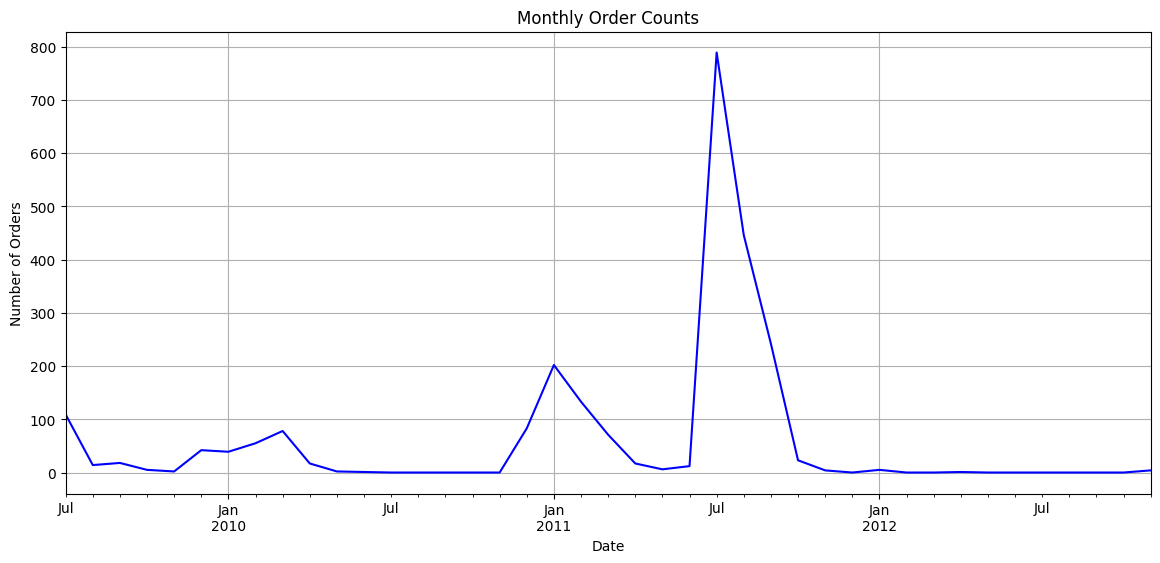

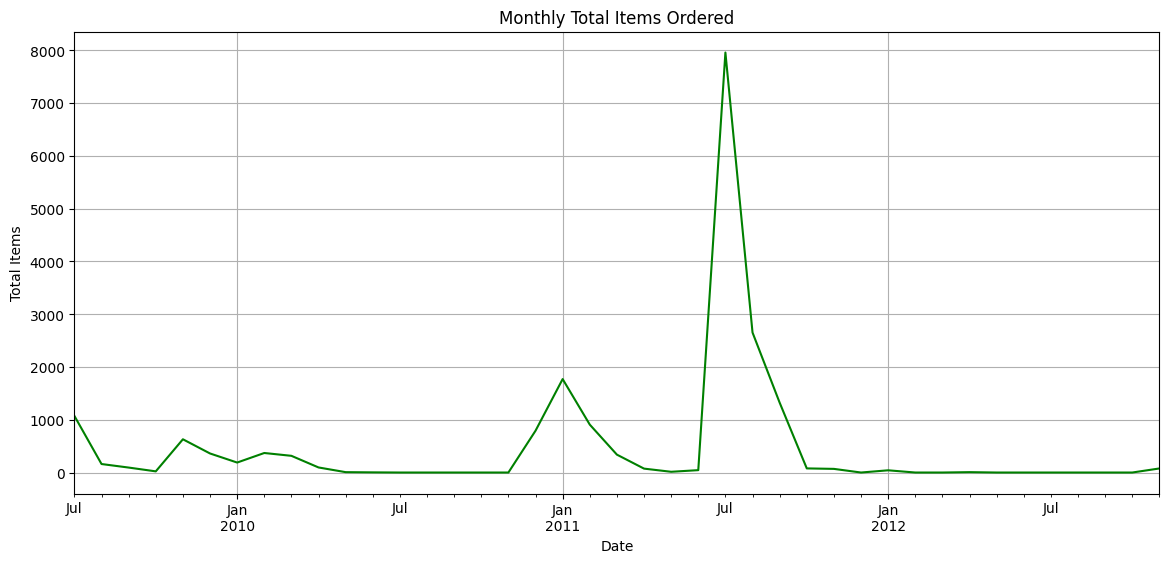

In [ ]:
import matplotlib.pyplot as plt

# Setting the figure size for the plots
plt.rcParams['figure.figsize'] = [14, 6]

# Create a monthly time series of order counts
monthly_order_counts = df.set_index('order_date').resample('M').size()

# Create a monthly time series of the total number of items ordered
monthly_items_sum = df.set_index('order_date').resample('M')['items'].sum()

# Plotting the monthly order counts
plt.figure(1)
monthly_order_counts.plot(title='Monthly Order Counts', color='blue')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()

# Plotting the monthly total number of items ordered
plt.figure(2)
monthly_items_sum.plot(title='Monthly Total Items Ordered', color='green')
plt.xlabel('Date')
plt.ylabel('Total Items')
plt.grid(True)
plt.show()


##### 3. Aggregate Demand Analysis

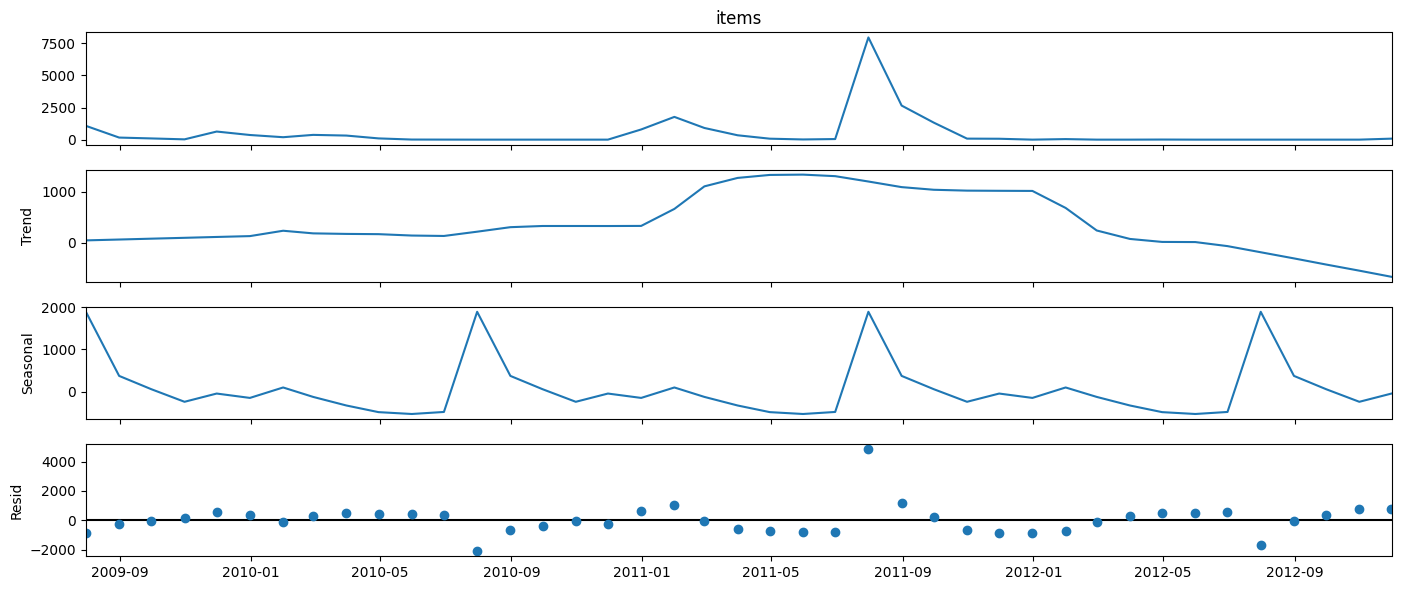

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Aggregate the total number of items ordered on a monthly basis for all products
total_monthly_demand = df.set_index('order_date').resample('M')['items'].sum()

# Decompose the time series using STL
decomposition = seasonal_decompose(total_monthly_demand, model='additive', extrapolate_trend='freq')

# Plotting the decomposed time series components
decomposition.plot()
plt.show()

In [ ]:
# Calculate the lead time (in days)
df['lead_time'] = (df['requested_delivery_date'] - df['order_date']).dt.days

In [ ]:
# Extract month from 'order_date' and 'requested_delivery_date' to capture seasonal effects
df['order_month'] = df['order_date'].dt.month
df['delivery_month'] = df['requested_delivery_date'].dt.month

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encode the categorical features
categorical_features = df[['Customer Country Code', 'Curr', 'Route']]
encoder = OneHotEncoder(sparse=False)
encoded_categorical_features = encoder.fit_transform(categorical_features)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# Combine the encoded categorical features with the numeric features
numeric_features = df[['value', 'lead_time', 'order_month', 'delivery_month']].to_numpy()
X = np.hstack((encoded_categorical_features, numeric_features))

In [ ]:
# Define 'target_sku' as the first product code in the dataset for demonstration purposes
target_sku = df['Product Code'].unique()[0]

In [ ]:
# Create a binary target variable for the chosen SKU
df['target'] = (df['Product Code'] == target_sku).astype(int)

In [ ]:
# The target variable for the first product code
y = df['target'].to_numpy()

In [ ]:
# Check the shape of the features and target arrays
print(X.shape, y.shape)

(2420, 78) (2420,)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Split the encoded features and target variable into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the logistic regression model for the first SKU
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)  # Training for the first SKU

# Predicting the test set results and calculating the accuracy
y_pred = logreg.predict(X_test)

# Evaluating the model
report = classification_report(y_test, y_pred, output_dict=True)

report

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 483},
 '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 484},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 484}}

Logistic Regression is not good, we try to use random forest

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

# Assuming X and y are already defined as before

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handling class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train a Random Forest Classifier with adjusted hyperparameters
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train_smote, y_train_smote)

# Predicting the test set results
y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]

# Confusion Matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# AUC-ROC Score for Random Forest
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

conf_matrix_rf, roc_auc_rf


(array([[467,  16],
        [  0,   1]]),
 0.9917184265010351)

In [ ]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handling class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Retrain the RandomForestClassifier
rf_retrained = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_retrained.fit(X_train_smote, y_train_smote)


RandomForestClassifier(max_depth=10, random_state=42)

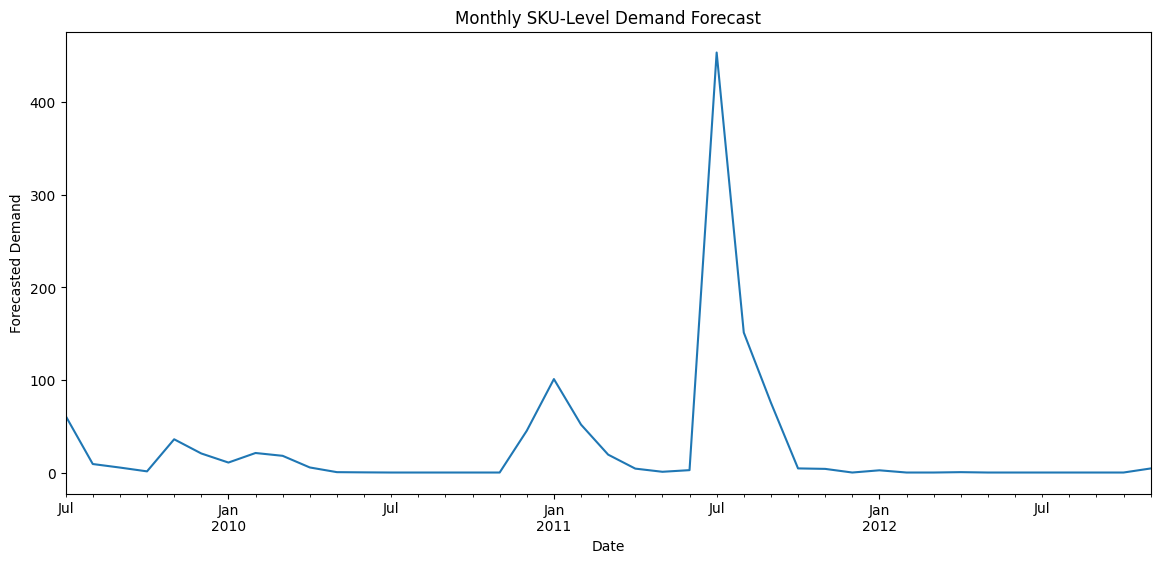

In [ ]:
# Estimating the choice probabilities
sku_choice_probabilities = rf_retrained.predict_proba(X)[:, 1]

# Calculate monthly aggregate demand
monthly_aggregate_demand = df.set_index('order_date').resample('M')['items'].sum()

# Apply choice probabilities to aggregate demand
avg_sku_choice_probability = np.mean(sku_choice_probabilities)
monthly_sku_forecast = monthly_aggregate_demand * avg_sku_choice_probability

# Plotting the forecast
monthly_sku_forecast.plot(title="Monthly SKU-Level Demand Forecast")
plt.xlabel("Date")
plt.ylabel("Forecasted Demand")
plt.show()

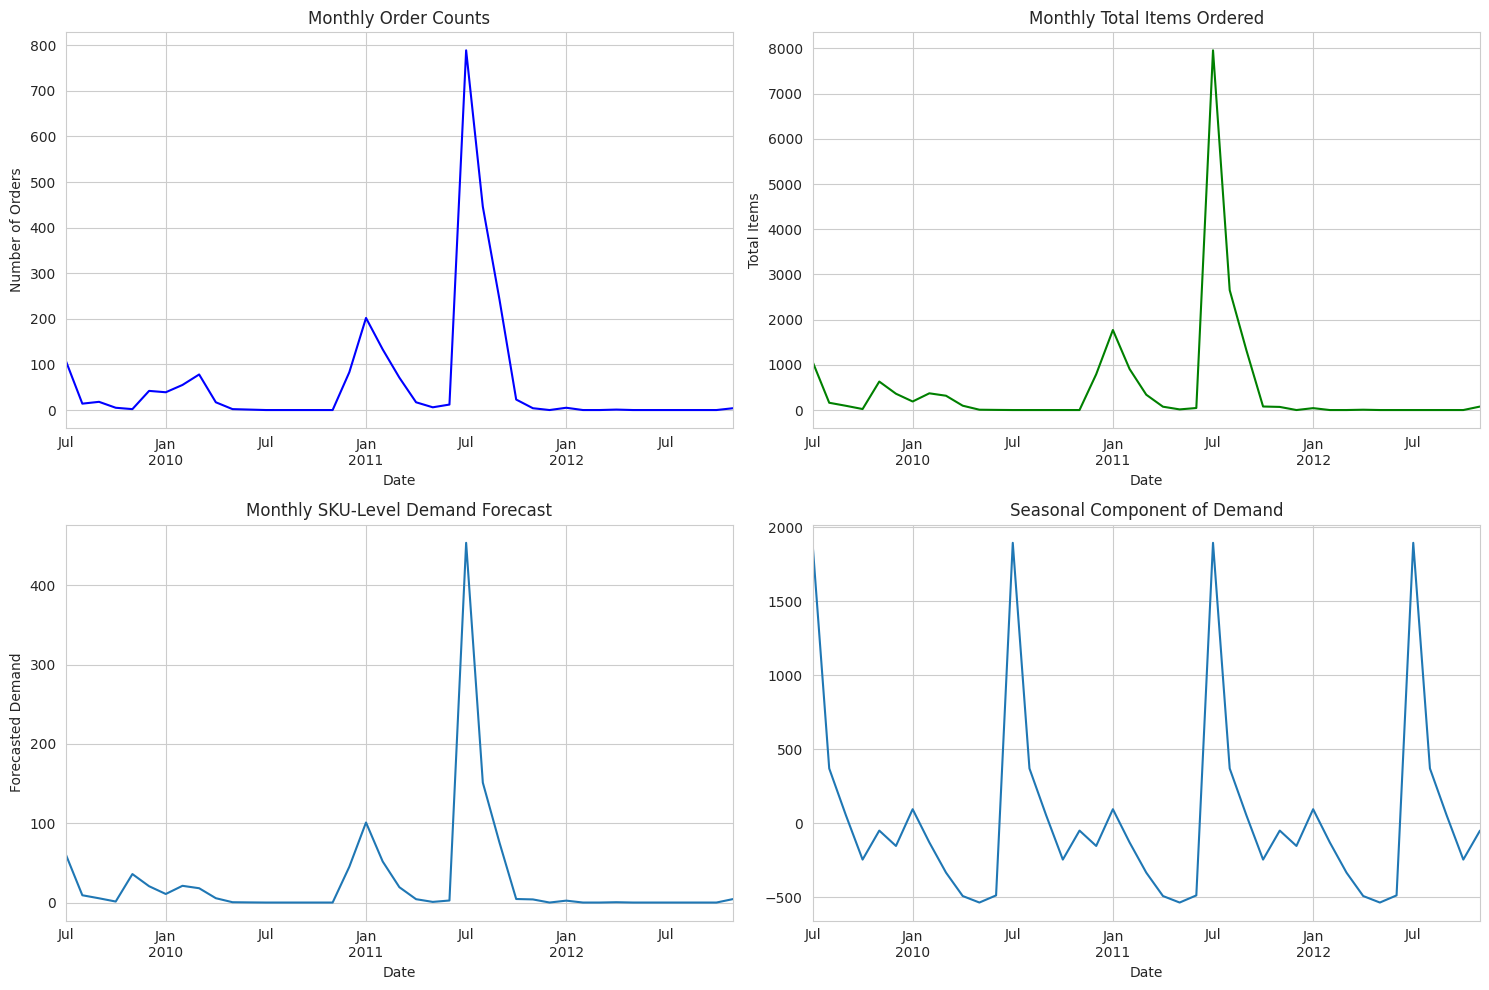

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sample code to create a dashboard of key metrics

# Setting the aesthetics for the plots
sns.set_style("whitegrid")

# Create a figure with specified size
plt.figure(figsize=(15, 10))

# Subplot 1: Monthly Order Counts
plt.subplot(2, 2, 1)
monthly_order_counts.plot(title='Monthly Order Counts', color='blue')
plt.xlabel('Date')
plt.ylabel('Number of Orders')

# Subplot 2: Monthly Total Items Ordered
plt.subplot(2, 2, 2)
monthly_items_sum.plot(title='Monthly Total Items Ordered', color='green')
plt.xlabel('Date')
plt.ylabel('Total Items')

# Subplot 3: Monthly SKU-Level Demand Forecast
plt.subplot(2, 2, 3)
monthly_sku_forecast.plot(title='Monthly SKU-Level Demand Forecast')
plt.xlabel('Date')
plt.ylabel('Forecasted Demand')

# Subplot 4: Seasonality Decomposition
plt.subplot(2, 2, 4)
seasonal_plot = decomposition.seasonal.plot(title='Seasonal Component of Demand')
plt.xlabel('Date')

# Adjust the layout
plt.tight_layout()
plt.show()


##### 4. Demand Estimation Model Based on Advance Orders

In [ ]:
# Define a threshold for what constitutes an 'advance order'
advance_order_threshold = 30  # days

In [ ]:
# Identify advance orders
df['is_advance_order'] = df['lead_time'] > advance_order_threshold

In [ ]:
# Aggregate the total number of items ordered in advance each month
monthly_advance_orders = df[df['is_advance_order']].resample('M', on='order_date')['items'].sum()


In [ ]:
pip install statsmodels


In [ ]:
import statsmodels.api as sm

In [ ]:
# Define the SARIMA model
# The order (p, d, q) and seasonal order (P, D, Q, s) need to be defined
# Let's start with a simple model, you might need to adjust these parameters
model = sm.tsa.statespace.SARIMAX(monthly_advance_orders,
                                  order=(1, 1, 1),
                                  seasonal_order=(1, 1, 1, 12),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

# Fit the model
sarima_model = model.fit()

# Print out the model summary
print(sarima_model.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                              items   No. Observations:                   34
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -45.112
Date:                            Mon, 11 Dec 2023   AIC                            100.224
Time:                                    23:12:39   BIC                             99.953
Sample:                                07-31-2009   HQIC                            96.881
                                     - 04-30-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6424      0.049     13.008      0.000       0.546       0.739
ma.L1         -0.2042      0.639   

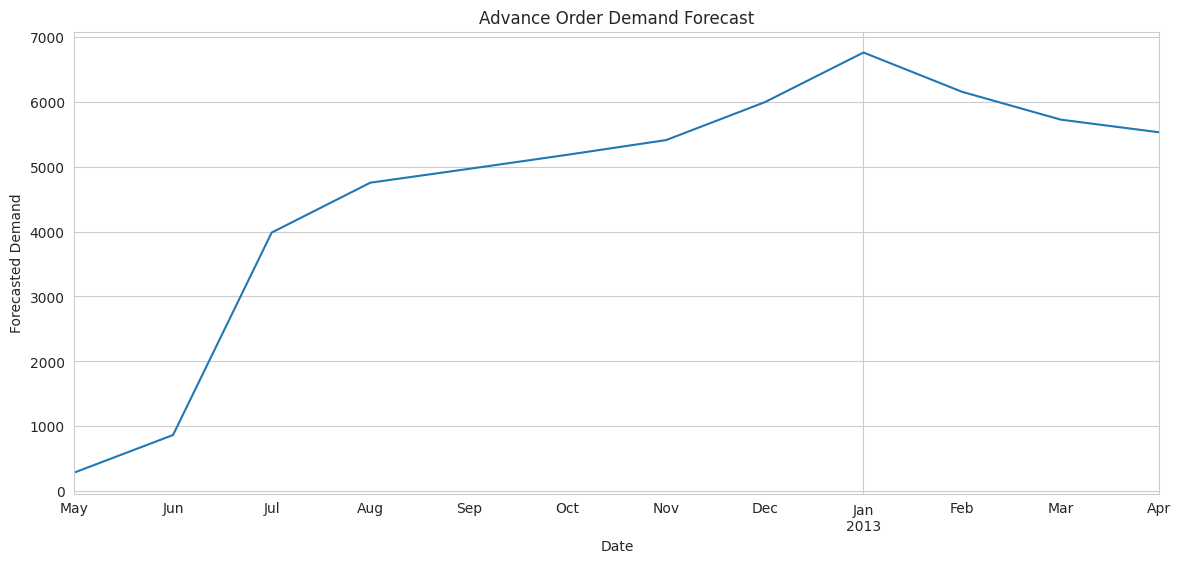

In [ ]:
# Forecasting the next 12 months
forecast = sarima_model.get_forecast(steps=12)
forecast_df = forecast.conf_int()
forecast_df['forecast'] = sarima_model.predict(start=forecast_df.index[0], end=forecast_df.index[-1])

# Plot the forecast
forecast_df['forecast'].plot(title='Advance Order Demand Forecast')
plt.xlabel('Date')
plt.ylabel('Forecasted Demand')
plt.show()
